# K-Means Clustering with sklearn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%autosave 180

Autosaving every 180 seconds


In [2]:
from sklearn.datasets import make_blobs

raw_data = make_blobs(n_samples = 1000, n_features = 2, centers = 20, cluster_std = 0.9)
# plt.scatter(raw_data[0][:,0], raw_data[0][:,1], c=raw_data[1])


took 1.027162790298462 seconds


<IPython.core.display.Javascript object>


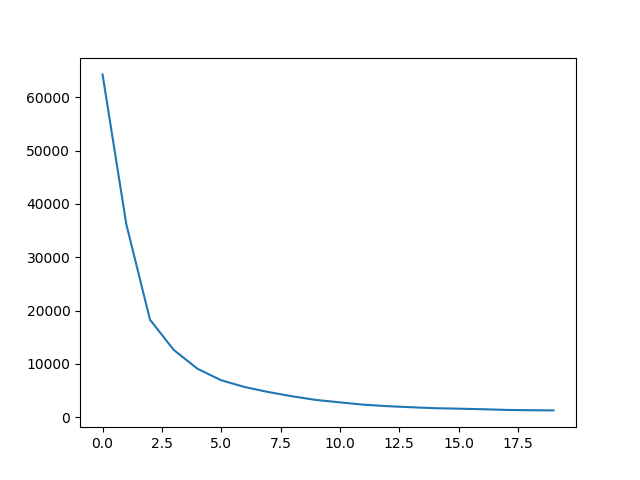

In [3]:
from sklearn.cluster import KMeans
start = time.time()

mnc = 20 #max number of clusters
err = np.zeros([mnc,1])

for i in range(mnc):
    km = KMeans(n_clusters= i + 1)
    km.fit(raw_data[0])
    err[i] = km.inertia_

# print("\n estiamted cluster centers: \n", km.cluster_centers_)
# print(km.__doc__)

print("took", time.time()-start, "seconds")
plt.plot(err)

<IPython.core.display.Javascript object>


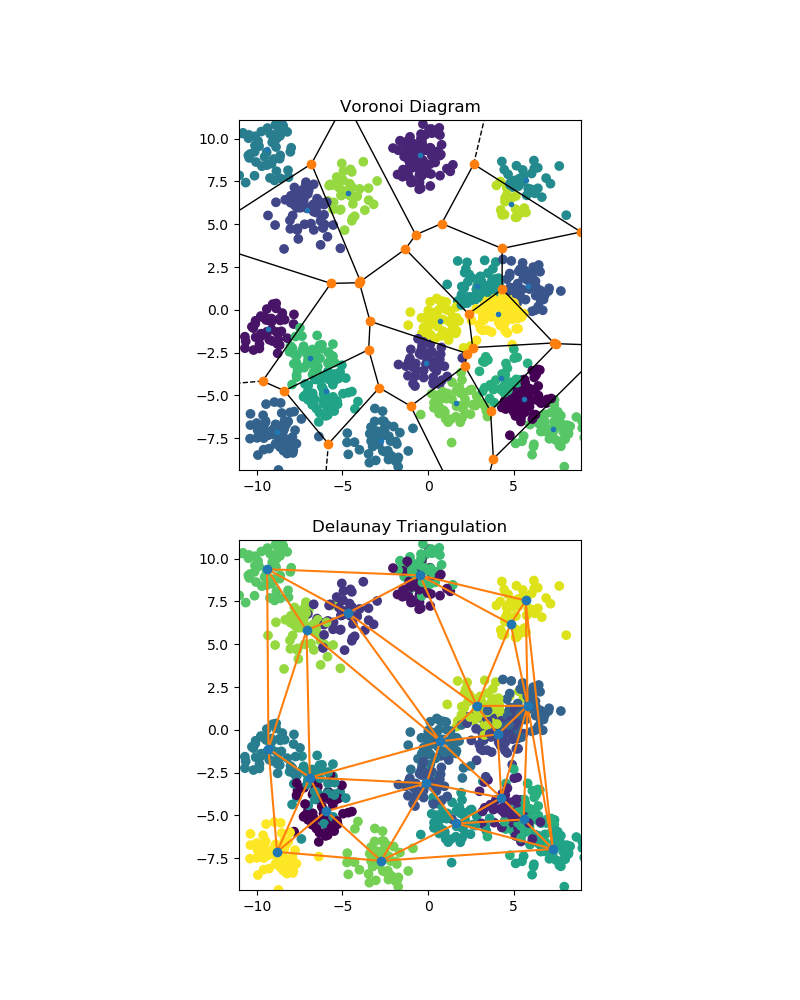

In [4]:
# import scipy
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay, delaunay_plot_2d

V = Voronoi(points = km.cluster_centers_)
Dny = Delaunay(points = km.cluster_centers_)
# fig = voronoi_plot_2d(V)
# ax.set_aspect('equal')

f, (ax1, ax2) = plt.subplots(2,1, sharey=True,figsize=(8,10))

ax1.set_title('Voronoi Diagram')
fig = voronoi_plot_2d(V, ax1)
ax1.scatter(raw_data[0][:,0], raw_data[0][:,1],c=km.labels_)
ax1.set_aspect('equal')

ax2.set_title('Delaunay Triangulation')
fig = delaunay_plot_2d(Dny, ax2)
ax2.scatter(raw_data[0][:,0], raw_data[0][:,1],c=raw_data[1])
ax2.set_aspect('equal')

<IPython.core.display.Javascript object>


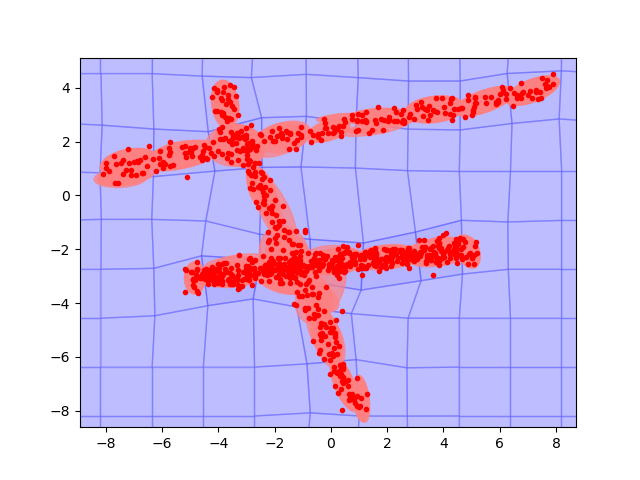

In [5]:
from divide import divide

fig3 = plt.figure()
ax3 = fig3.add_subplot()

D = divide(fig3, ax3, n = 3)

#see how voronoi diagrams produce similar results to grandient descenet on voxel edges

<IPython.core.display.Javascript object>


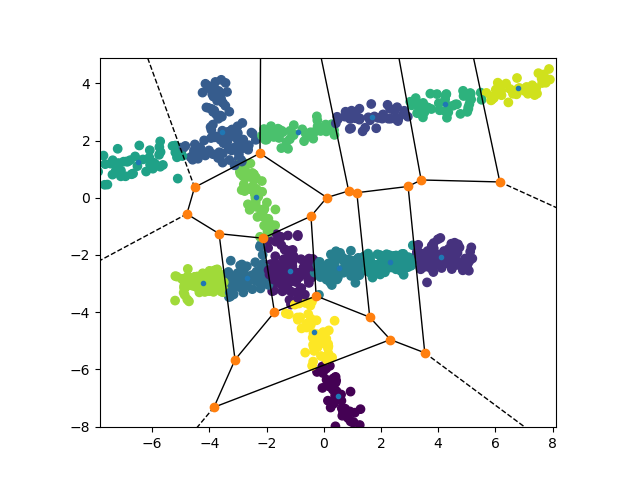

In [8]:
km = KMeans(n_clusters = 15)
km.fit(D.cloud)

fig4 = plt.figure()
ax4 = fig4.add_subplot()

V = Voronoi(points = km.cluster_centers_)
# print(V.vertices)
# print(V.regions)

fig4 = voronoi_plot_2d(V, ax4)
ax4.scatter(D.cloud[:,0], D.cloud[:,1],c=km.labels_)
ax4.set_aspect('equal')


In [ ]:
# https://freud.readthedocs.io/en/v1.2.0/examples/examples/Visualizing%203D%20Voronoi%20and%20Voxelization.html

# Find 2D convex hull of points containted within a Voronoi cell

<IPython.core.display.Javascript object>


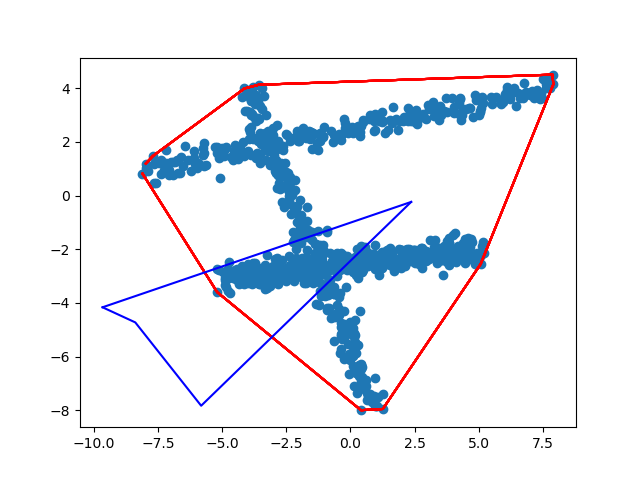

In [6]:
import scipy.spatial
from scipy.spatial import ConvexHull

fig5, ax5 = plt.subplots(1)
ax5.scatter(D.cloud[:,0], D.cloud[:,1])

hull = ConvexHull(points = D.cloud, incremental = False)
# print(hull.vertices) #contains points on border
# print(hull.area)
# print(hull.equations) # [normal unit vector, offset]
# print(hull.__doc__)

#draw convex hull of entire point cloud
for i in range(np.shape(hull.vertices)[0]):
    ax5.plot(D.cloud[hull.vertices, 0], D.cloud[hull.vertices, 1], 'r-')

#draw rubber band around the vertices containing the points in group j
# print(V.vertices)
# print(V.regions)
# print(V.point_region) #idx of region for each input point
# for j in range(len(V.regions) - 1):
for j in range(4,5): #just do a single voxel
    p = V.vertices[V.regions[j+1]]
    if np.shape(p)[0] > 0: #TODO- don't draw when p has flagged '-1th' element
        ax5.plot(p[:,0], p[:,1], 'b-')
        ax5.plot([p[0,0], p[-1,0]], [p[0,1], p[-1,1]], 'b-') # becuase we need to close the shape
    
    #identify all points in scan that lie within polygon p
        #Note: we have information on what points from scan 1 are in p (since that's how we figured 
        #      out our Voronoi cell centers, but we need to use the same cells for both scans)


<IPython.core.display.Javascript object>


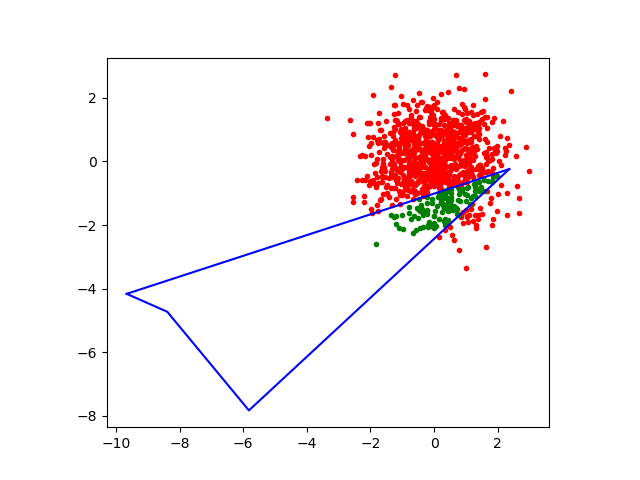

In [7]:
#find points in new point cloud that fall within the bounds of hull Z
        # https://stackoverflow.com/questions/16750618/whats-an-efficient-way-to-find-if-a-point-lies-in-the-convex-hull-of-a-point-cl#:~:text=For%20each%20of%20the%20edges,it%20lies%20outside%20the%20polygon.
from scipy.optimize import linprog
import warnings
warnings.simplefilter("ignore") #to fix repeated deprication warnings in scipy.optimize.linprog

fig6, ax6 = plt.subplots(1)

def in_hull(points, x):
    n_points = len(points)
    n_dim = len(x)
    c = np.zeros([n_points])
    A = np.r_[points.T,np.ones([1,n_points])]
    b = np.r_[x, np.ones([1])]
    lp = linprog(c, A_eq=A, b_eq=b);
    return lp.success

Z = V.vertices[V.regions[5]]
x = np.random.randn(1000, 2)

for i in range(np.shape(x)[0]):
#     print(in_hull(Z, x[i]))
    inside = in_hull(Z, x[i]);
    if inside == True:
        ax6.plot(x[i,0], x[i,1], 'g.')
    else:
        ax6.plot(x[i,0], x[i,1], 'r.')
        
ax6.set_aspect('equal')
ax6.plot(Z[:,0], Z[:,1], 'b-')
ax6.plot([Z[0,0], Z[-1,0]], [Z[0,1], Z[-1,1]], 'b-')


# 3D Clustering

In [10]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti

settings.embedWindow(backend='ipyvtk', verbose = True)
plt2 = Plotter(N=1, axes=7, bg = (1,1,1),  interactive=True)

## init KITTI dataset -----------------------------------------------------------------
basedir = 'C:/kitti/'
date = '2011_09_26'
drive = '0005'
frame_range = range(150, 151, 1)
dataset = pykitti.raw(basedir, date, drive)
velo1 = dataset.get_velo(0) # Each scan is a Nx4 array of [x,y,z,reflectance]
cloud = velo1[:,:3]
# cloud = cloud[cloud[:,2] > -1.5] #ignore ground plane
## ------------------------------------------------------------------------------------

disp = []
c = Points(cloud, c = [1,0,0])
disp.append(c)

plt2.show(disp)
ViewInteractiveWidget(plt2.window)


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [11]:
nc = 50
#TODO: pass in initial centroid estimates as regular voxel grid coords?
km = KMeans(n_clusters = nc)
km.fit(cloud) #use every point
# km.fit(cloud[0:-1:3,:]) #do kmeans using a subset of all points
ctrs = Points(km.cluster_centers_, c = [0,0,1], r =10)
disp = []
disp.append(ctrs)
disp.append(c)
# plt2.show(disp)

In [12]:
#create Voronoi plot data from cluster centers
# V = Voronoi(points = km.cluster_centers_)

#get which cluster every point belongs to
# print(km.__doc__)
# print(km.labels_) #describes wich cluster each point in cloud belongs to
# print(km.cluster_centers_) #coords of each cluster center

disp = []
for i in range(nc):
    idx = np.where(km.labels_ == i)
    c = Points(cloud[idx], c = [np.random.rand(), np.random.rand(), np.random.rand() ], r = 5 )
    disp.append(c)
plt2.show(disp)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [16]:
print(np.shape(cloud[1:-1:100,:]))

(1234, 3)
